# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs, and it is encouraged for you to do so. Especially during covid and distancing, this can be a way to work with other students and learn alongside one another. As future data scientists, you will often be expected to work with others, and working in pairs can help practice communicating data science concepts.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with a long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them. .
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example: 
```
print(f'The R^2 is {R:.4f}')
```

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

## Contents
- [Question 1 [20pts]: A Single Model](#Question-1-[20pts]:-A-Single-Model) 
- [Question 2 [25pts]: Bagging](#Question-2-[25pts]:-Bagging) 
- [Question 3 [20pts]: Random Forests](#Question-3-[20pts]:-Random-Forests) 
- [Question 4 [20pts]: Boosting](#Question-4-[20pts]:-Boosting) 
- [Question 5 [15pts]: Understanding](#Question-5-[15pts]:-Understanding) 

### <div class='exercise'>Question 1 [20pts]: A Single Model</div>
[▲ Return to contents](#Contents)
<div class='exercise'>
    
We start by fitting a basic model, which will serve as our baseline model -- a model that we can use as a starting point and can reasonably compare to other models. We will pick a decision tree as our baseline model, and we will later include bagging, random forests, and boosting. We want a fair comparison, so it is important to keep important aspects of the experiments consistent (e.g., the training/dev/testing data). We will tune the decision tree using cross-validation (of course). We will tune the maximum tree depth; we refer to this hyper-parameter as "depth" for simplicity.

Since we will only use tree-based methods in this homework, we do not need to standardize or normalize the predictors/independent variables. 

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, using tree depths from 1 to 20 (inclusive):
- fit a decision tree to the **training** set
- evaluate on the **training** set (i.e., `.score()`), while storing the scores in a variable named `train_scores`
- using cross-validation, evaluate on the **training** set while storing the mean and +/- 2 standard deviations in variables named `cvmeans` and `cvstds`, respectively.

Now that we have these informative scores, let us plot them. Specifically, for each tree-depth (x-axis) plot on the y-axis: (a) the initial, non-cross-validation training scores; and (b) a shaded region that illustrates cross-validations' estimated mean +/- 2 standard deviations. (c) set the limits on the y-axis to focus on the cross-validation performance.

*Hint:* use `plt.fill_between()` to shade the region.
    
**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracy on the **test** set. Store the training and testing accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

**1.3** What is the name of the mechanism by which limiting the tree's depth avoids over-fitting? What is one downside of limiting the tree depth? 
    
</div>

## Answers

<div class='exercise-r'>  
 
**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, using tree depths from 1 to 20 (inclusive):
 - fit a decision tree to the **training** set
 - evaluate on the **training** set (i.e., `.score()`), while storing the scores in a variable named `train_scores`
 - using cross-validation, evaluate on the **training** set while storing the mean and +/- 2 standard deviations in variables named `cvmeans` and `cvstds`, respectively.
 
 Now that we have these informative scores, let us plot them. Specifically, for each tree-depth (x-axis) plot on the y-axis: (a) the initial, non-cross-validation training scores; and (b) a shaded region that illustrates cross-validations' estimated mean +/- 2 standard deviations. (c) set the limits on the y-axis to focus on the cross-validation performance.
 
 *Hint:* use `plt.fill_between()` to shade the region.
 
 </div>

In [6]:
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    for d in depths:
        dtree = DecisionTreeClassifier(max_depth=d)
        dtree.fit(X_train,y_train)
        train_scores.append(dtree.score(X_train,y_train))
        cv_score = cross_val_score(dtree, X_train, y_train)
        cvmeans.append(np.mean(abs(cv_score)))
        cvstds.append(2*np.std(abs(cv_score)))
    # end of your code here
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores= calc_meanstd(X_train, y_train, depths)

Text(0, 0.5, 'Classification Score')

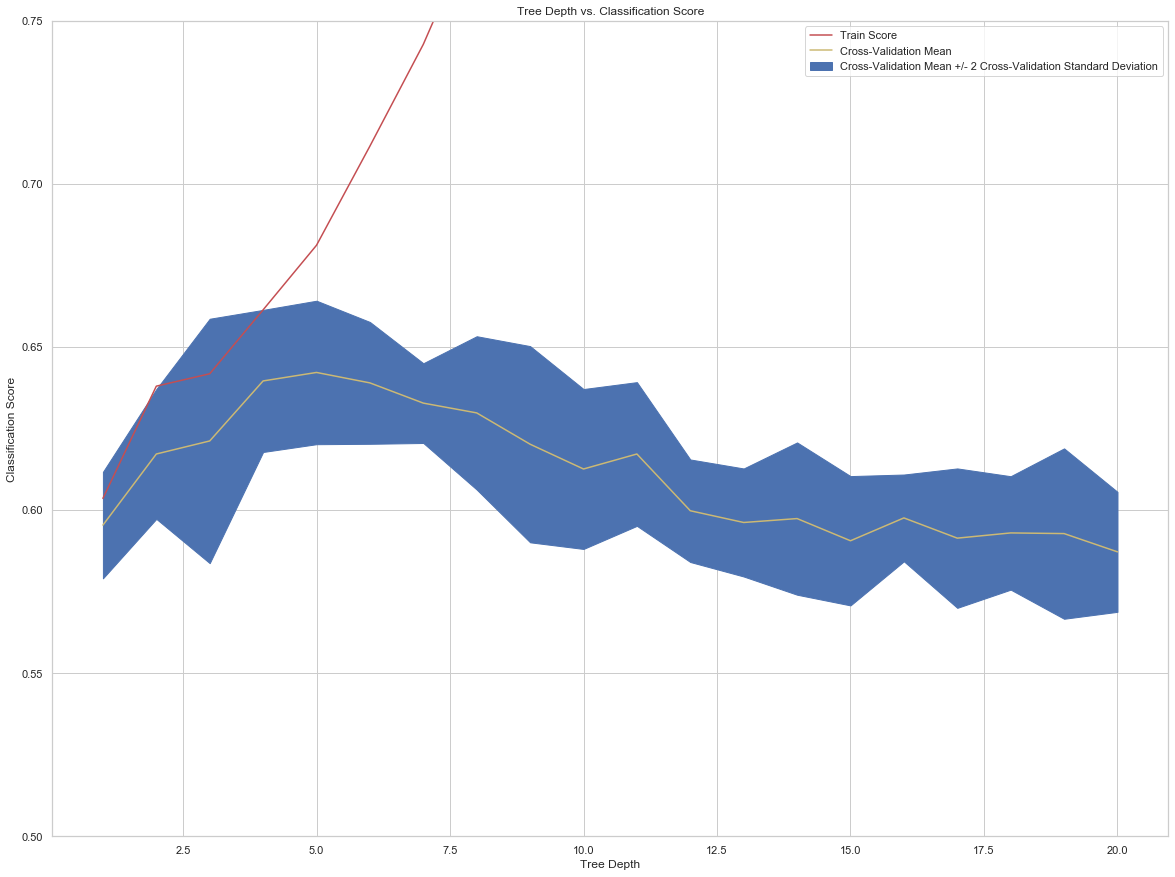

In [7]:
# your code here 
plt.figure(figsize=(20,15))
plt.plot(depths, train_scores, color = 'r', label='Train Score')
plt.fill_between(depths, [i + j for i, j in zip(cvmeans,cvstds)], [i - j for i, j in zip(cvmeans,cvstds)],
                 label='Cross-Validation Mean +/- 2 Cross-Validation Standard Deviation', color = 'b')
plt.plot(depths, cvmeans, color = 'y', label = 'Cross-Validation Mean')
plt.legend()
plt.ylim(0.5,0.75)
plt.title('Tree Depth vs. Classification Score')
plt.xlabel('Tree Depth')
plt.ylabel('Classification Score')

<div class='exercise-r'>  
 
**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracy on the **test** set. Store the training and testing accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.
 
 </div>

In [8]:
# your code here
chosen_depth = np.argmax(cvmeans)+1

dtree1_2 = DecisionTreeClassifier(max_depth=chosen_depth).fit(X_train, y_train)
best_cv_tree_train_score = dtree1_2.score(X_train, y_train)
best_cv_tree_test_score = dtree1_2.score(X_test, y_test)

print('The chosen best tree depth is: ' + str(chosen_depth))
print('The classification accuracy on the test set is: ' + str(round(best_cv_tree_test_score,4)))

The chosen best tree depth is: 5
The classification accuracy on the test set is: 0.6482


In [9]:
best_cv_tree_train_score , best_cv_tree_test_score

(0.6812, 0.6482)

*Your answer here*

Here our chosen depth is 5 because that tree depth had the highest cross-validation classification score.  Additionally, it had the highest classification score even with the 2+/- standard deviations from the mean. Observe that 2 standard deviations below the mean at the depth of 5 is no lower than 2 standard deviations below the mean of any other depth (except for a depth of 6), and that 2 standard deviations above the mean at the depth of 5 is higher than 2 standard deviations above the mean of any other depth.

<div class='exercise-r'>  
 
**1.3** What is the name of the mechanism by which limiting the tree's depth avoids over-fitting? What is one downside of limiting the tree depth?
 
 </div>

*Your answer here*

Pruning (a method of selecting a stopping condition) is the mechanism we use to limit tree depth.  We can either pre-prune the tree, meaning we limit the tree depth before fitting the tree.  Or we could post-prune the tree where we fit the tree then go back through it to determine the optimal depth.  Here we used post-pruning to chose our best tree depth by selecting the tree depth that yielded the highest cross-validation classification score. Pruning is subject to the bias-variance tradeoff, where by pruning we lower the complexity of the tree (limiting the tree depth) so we are reducing the variance of our predictions, but we suffer from the downside of greater bias from limiting tree depth.

### <div class='exercise'>Question 2 [25pts]: Bagging</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
Bagging is the technique of building the same model on multiple bootstrap samples from the data and combining each model's prediction to get an overall classification. In this question, we build an example by hand and study how the number of bootstrapped datasets impacts the resulting classification accuracy.



**2.1** Using decision trees and the previous question's data, choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 55 bootstrapped replications of the original training data and fit a decision tree to each (using the tree depth you just chose in 2.1). Record each of the 55 trees' predictions. In particular, produce a dataset like those shown below, where each row is either a training and testing observation (depending on the partition of data at hand), and each column is one of the 55 trees. Each entry within a (row, col) is the corresponding tree's prediction for that observation.

Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.

**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging test accuracy to a variable named `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions()` function (given below) to get the model's accuracy score when using only $N$ of the bootstrapped models, where $N \in [1, 2, 3, ..., 55]$. Make a plot that illustrates the accuracy on the training set and testing set, as a function of the number of bootstraps (vary $N$ from 1 to 55). 
**Use the depth from 2.1** 

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample()` from `sklearn` to easily bootstrap the $x$ and $y$ data.
- use `np.mean()` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?
    
</div>

## Answers

<div class='exercise-r'>  
 
**2.1** Using decision trees and the previous question's data, choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below.)
 
 </div>

In [10]:
# Assign your choice to a variable named tree_depth
# your code here
tree_depth = 20

*Your answer here*

From the above cross validation plot we can see that a tree depth of 20 had the lowest mean cross-validation classification score. Moreover, beyond a depth of 5 the mean cross-validation classification scores decreased for higher tree depths, thus indicating that a tree depth of 20 was the most overfit model.  It is likely that if we'd picked an even greater depth for the tree we would be overfitting the model even further but 20 was the maximum from the previous section.

<div class='exercise-r'>  
 
**2.2** Create 55 bootstrapped replications of the original training data and fit a decision tree to each (using the tree depth you just chose in 2.1). Record each of the 55 trees' predictions. In particular, produce a dataset like those shown below, where each row is either a training and testing observation (depending on the partition of data at hand), and each column is one of the 55 trees. Each entry within a (row, col) is the corresponding tree's prediction for that observation.
 
 Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.
 
 </div>

**Structure of `bagging_train_df` and `bagging_test_df`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 55's prediction|  
| --- | --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 55's prediction|
| --- | --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


In [11]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    # your code here
    bagging_models = []
    train_predictions = []
    test_predictions = []
    
    for i in range(n_trees):
        # sample data to perform first bootstrap, here, we actually bootstrap indices, because we want the same subset for X_train and y_train
        resample_indexes = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0])
        
        # get bootstrapped set for 'X' and 'y' using the above indices
        X_boot = X_train[resample_indexes]
        y_boot = y_train[resample_indexes]
        
        # train decision tree on bootstrap set, use the tree_depth and random_seed inputs
        clf = DecisionTreeClassifier(max_depth=tree_depth, random_state=random_seed)
        
        # fit the model on bootstrapped training set
        clf.fit(X_boot,y_boot)
        
        # append model to bagging_models list
        bagging_models.append(clf)
        
        # make predictions on X_train and X_test and append to train_predictions and test_predictions lists
        train_predictions.append(clf.predict(X_train))
        test_predictions.append(clf.predict(X_test))
    
    # create bagging_training dataframe
    bagging_train = pd.DataFrame(data = list(zip(*train_predictions)),
                                 columns = list('bootstrap model ' + str(i+1) +'\'s prediction'
                                                for i in range(len(train_predictions))),
                                 index = list('training row ' + str(i+1)
                                              for i in range(len(train_predictions[0]))))
    
    # create bagging_training dataframe
    bagging_test = pd.DataFrame(data = list(zip(*test_predictions)),
                                columns = list('bootstrap model ' + str(i+1) +'\'s prediction'
                                                for i in range(len(test_predictions))),
                                 index = list('training row ' + str(i+1)
                                              for i in range(len(test_predictions[0]))))
    
    return bagging_train, bagging_test, bagging_models

In [12]:
# your code here
n_trees = 55
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth)

<div class='exercise-r'>  
 
**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging test accuracy to a variable named `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in Question 1.
 
 </div>

In [13]:
# your code here
# Get combined prediction by finding mode of every row for the training and testing set
aggregate_train_predictions = bagging_train_df.mode(axis=1)
aggregate_test_predictions = bagging_test_df.mode(axis=1)

# Calculate bagging train accuracy
bagging_accuracy_train = accuracy_score(y_train, aggregate_train_predictions)
# Calculate bagging test accuracy
bagging_accuracy_test = accuracy_score(y_test, aggregate_test_predictions)

print('The accuracy of the bagging model on test set is: ' + str(round(bagging_accuracy_test,4)))
if bagging_accuracy_test >= best_cv_tree_test_score:
    print('This test set accuracy is at least as good as the accuracy for the model fitted in Question 1')
else:
    print('This test set accuracy is not at least as good as the accuracy for the model fitted in Question 1')

The accuracy of the bagging model on test set is: 0.6948
This test set accuracy is at least as good as the accuracy for the model fitted in Question 1


<div class='exercise-r'>  
 
**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions()` function (given below) to get the model's accuracy score when using only $N$ of the bootstrapped models, where $N \in [1, 2, 3, ..., 55]$. Make a plot that illustrates the accuracy on the training set and testing set, as a function of the number of bootstraps (vary $N$ from 1 to 55).
 **Use the depth from 2.1**
 
 On your plot, also include horizontal lines for two baselines:
 - the test accuracy of the best model from question 1
 - the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.
 
 </div>

In [14]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

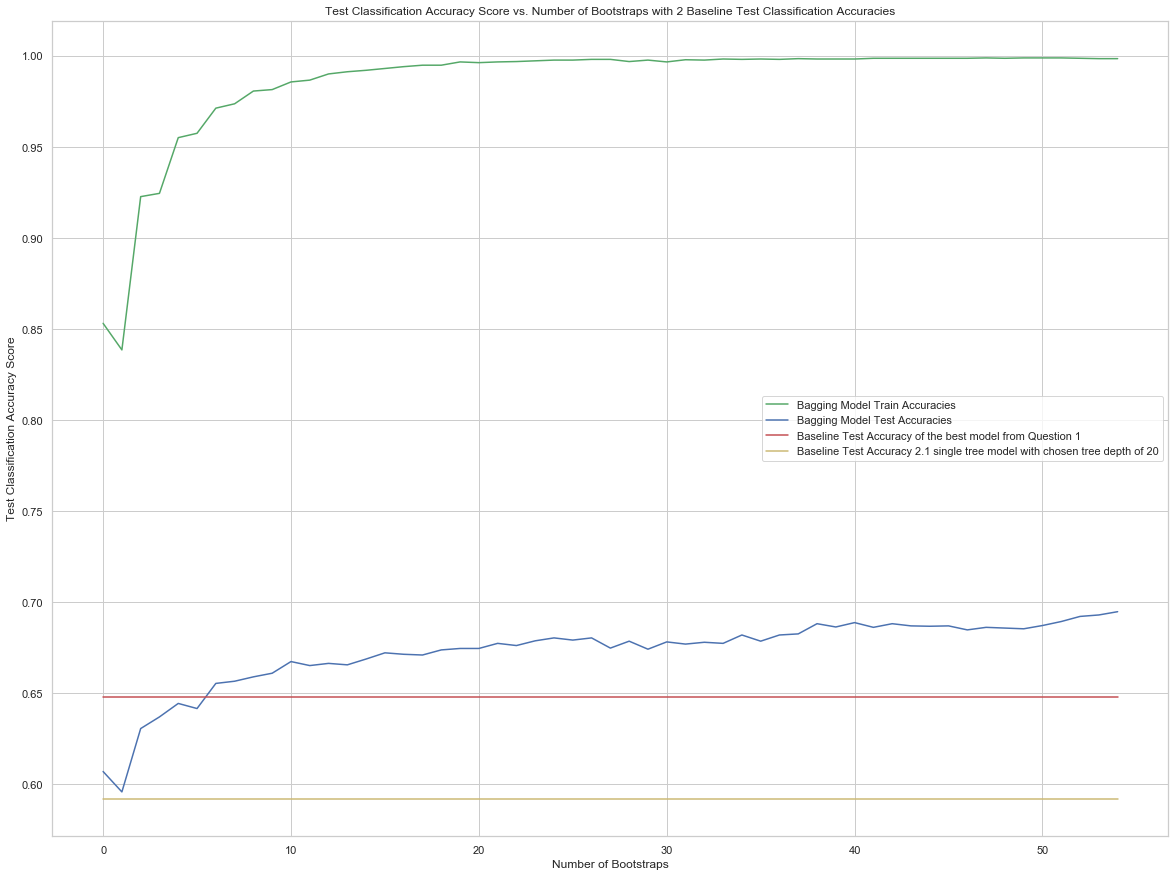

In [15]:
# plotting code
# your code here

# fit model on the full training set of the single tree model with tree depth chosen from 2.1
dtree2_1 = DecisionTreeClassifier(max_depth=tree_depth).fit(X_train, y_train)
# calculate training accuracy
dtree2_1_train_accuracy = dtree2_1.score(X_train,y_train)
# calculate test accuracy
dtree2_1_test_accuracy = dtree2_1.score(X_test,y_test)

# use function above to obtain list of accuracies for each bootstrap
train_accuracies = running_predictions(bagging_train_df.to_numpy(), y_train)
test_accuracies = running_predictions(bagging_test_df.to_numpy(), y_test)

plt.figure(figsize=(20,15))
plt.plot(range(bagging_train_df.shape[1]),train_accuracies, color='g', label='Bagging Model Train Accuracies')
plt.plot(range(bagging_test_df.shape[1]),test_accuracies, color='b', label='Bagging Model Test Accuracies')
plt.plot(range(bagging_test_df.shape[1]),[best_cv_tree_test_score]*bagging_test_df.shape[1], color='r',
         label='Baseline Test Accuracy of the best model from Question 1')
plt.plot(range(bagging_test_df.shape[1]),[dtree2_1_test_accuracy]*bagging_test_df.shape[1], color='y',
         label='Baseline Test Accuracy 2.1 single tree model with chosen tree depth of ' + str(tree_depth))
plt.title('Test Classification Accuracy Score vs. Number of Bootstraps with 2 Baseline Test Classification Accuracies')
plt.xlabel('Number of Bootstraps')
plt.ylabel('Test Classification Accuracy Score')
plt.legend()

<div class='exercise-r'>  
 
**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.
 
 </div>

*Your answer here*

We can see that for the baseline single tree depth of 20 from question 2 it underpreforms the bagging model almost the entire time.  For bootstraps ~1-2 the baseline model seems to out preform or at least perform at the same level as the bagged model. More specifically, it seems that for 1 bootstrap the bagged model underperforms the baseline single tree depth of 20, but for 2 bootstraps the bagging model begins to outperform in terms of classification accuracy on the test data. However, very quickly we see a steep rise in the classification accuracy for the bagging model.  While it isn't a smooth perfect increase in the accuracy, the bagged model is clearly trending to higher and higher accuracy as the number of bootstraps is increased. Around 9 bootstraps, the bagging model begins to outperform the baseline single tree depth of 5 from question 1, and for more than 9 bootstraps, the bagging model continues to improve in accuracy and outperform the baseline single tree depth of 5, just like it did for the single tree depth of 20. Interestingly, the bagging model's score on the test set increases quickly with the number of bootstraps once it surpasses the baseline accuracy of tree depth 20, but around the baseline of tree depth 5, the improvements in the bagging model's score on the test set begins to increase at a slower rate.

<div class='exercise-r'>  
 
**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.
 
 </div>

*Your answer here*

As is evidenced by the figure produced in 2.4, when we limited the tree depth to the best depth (5) we see that the model was much more accurate than the clearly overfit model (depth = 20).  Again though, we can clearly see that after only a few bootstraps (more than 9 bootstraps), the bagging model begins to outpreform the limited depth model in terms of classification accuracy score on the test data set. This indicates that bagging is a better method for limiting overfitting provided that the number of bootstraps is significantly high enough. However, as we noted in 2.5, there are diminishing returns for the bagging model once we've crossed the baseline test accuracy of the tree depth of 5, so it appears that even the limiting tree depth approach does do a sufficient job of limiting most of the overfitting problem, since the bagging model only gives limited improvements on the test accuracy at the cost of many more bootstraps which can be computationally undesirable.

The main difference in the two approaches is the manner they take to limit overfitting. The limiting tree depth model takes the approach of using a simpler model that is more generalizable to different data sets, reducing the variance and limiting its potential to overfit. Bagging takes advantage of the Law of Large Numbers to make the model more robust from overfitting, since even if each bootstrapped tree model is overfit, by bootstrapping over many different samples of the data, the natural randomness of the bootstrap sampling means that the average of all of our overfitted tree models is more general than any of the individual tree models by themselves, meaning the aggregate bootstrapped model (the bagging model) has lower variance and is thus less prone to overfitting.

<div class='exercise-r'>  
 
**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?
 
 **Hints**
 - Use `resample()` from `sklearn` to easily bootstrap the $x$ and $y$ data.
 - use `np.mean()` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?
 
 </div>

*Your answer here*

First if we don't bootstrap a sufficient number of times, that means that our bagging model is not reducing variance as much as we desire and will still suffer from overfitting. Moreover, suppose the tree depth used in bagging is very high. If the data that we bootstrap over does not have sufficient variation that's representative of the true population (the true data) or by random chance all of our individual trees in our bootstrap are too similar, that means that the bagging model will still suffer from much of the overfitting problem that our individual trees do. Conversely, suppose the tree depth used in bagging is very low (shallow), then each individual tree in the bootstrap will severely underfit so the bagging model (since its the aggregate of the individual trees) will also underfit.

### <div class='exercise'>Question 3 [20pts]: Random Forests</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
Random Forests are closely related to the bagging model we built by hand in question 2. In this question, we compare our by-hand results with the results of using `RandomForestClassifier` directly.


**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2. Set the number of features to use when looking for the best split to be  `sqrt(total_number of features)`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.

**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them on the screen.

Explain:
* What about the process of training the Random Forest causes this difference?
* What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a Pandas table of the training and test accuracy for the following models and name it `results_df`:

- Single tree with the best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 55 such trees (from Question 2)
- A Random Forest of 55 such trees (from Question 3.1)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

</div>

## Answers

<div class='exercise-r'>  
 
**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2. Set the number of features to use when looking for the best split to be  `sqrt(total_number of features)`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.
 
 </div>

In [16]:
# your code here
# create RandomForestClassifier model
random_forest = RandomForestClassifier(max_depth=tree_depth, n_estimators = n_trees, max_features = 'sqrt')
# fit model on the training data
random_forest.fit(X_train, y_train)
# calculate the accuracy on the training set
random_forest_train_score = random_forest.score(X_train,y_train)
# calculate the accuracy on the test set
random_forest_test_score = random_forest.score(X_test,y_test)
# print out test score
print('Accuracy on the test set is: ' + str(round(random_forest_test_score,4)))

Accuracy on the test set is: 0.6902


<div class='exercise-r'>  
 
**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them on the screen.
 
 Explain:
 * What about the process of training the Random Forest causes this difference?
 * What implication does this observation have on the accuracy of bagging vs Random Forest?
 
 **Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
 
 </div>

In [17]:
# your code here

#defining variables 
bagging_top = []
rf_top = []

#Checking bagging features
for dec_t in bagging_models:
    bagging_top.append(dec_t.tree_.feature[0])

top_predictors_bagging = pd.Series(bagging_top)


#Checking random forest features 
for r_trees in random_forest.estimators_:
    rf_top.append(r_trees.tree_.feature[0])

top_predictors_rf = pd.Series(rf_top)

print('For the decision trees from bagging, the features in the top row are:')
for p in top_predictors_bagging.value_counts().index:
    print('Feature ' + str(p) + ' which is used ' + str(top_predictors_bagging.value_counts()[p]) + ' times')

print('\nFor the random forest model, the features in the top row are:')
for p in top_predictors_rf.value_counts().index:
    print('Feature ' + str(p) + ' which is used ' + str(top_predictors_rf.value_counts()[p]) + ' times')

For the decision trees from bagging, the features in the top row are:
Feature 25 which is used 55 times

For the random forest model, the features in the top row are:
Feature 27 which is used 7 times
Feature 26 which is used 7 times
Feature 25 which is used 7 times
Feature 22 which is used 7 times
Feature 3 which is used 5 times
Feature 0 which is used 5 times
Feature 24 which is used 4 times
Feature 11 which is used 3 times
Feature 9 which is used 2 times
Feature 5 which is used 2 times
Feature 1 which is used 2 times
Feature 21 which is used 1 times
Feature 17 which is used 1 times
Feature 12 which is used 1 times
Feature 6 which is used 1 times


*Your answer here*

For the bagging model we see that Feature 25 is used in the top node in all 55 bootstraps, but in the random foest we see that multiple different features are used in the top node, with Features 25, 26, and 27 being the top 3 most used top node features. This makes intuitive sense, since bagging is subject to correlation among the trees. Feature 25 is likely the strongest predictor so all 55 bootstrapped trees use it as the top node. In contrast, in Random Forest we decorrelate the trees by randomly selecting a subset of the features, resulting in different sets of features, some of which may not include Feature 25 and some of which may have other features having stronger effects than Feature 25. Random Forest ensures that we don't use the same features (and subsequently similar trees) in all of our bootstraps, but the features with the strongest effects are still selected the most often to be the top node. We expect the Random Forest to have a better accuracy on the test data and indeed our results are as we expected, where bagging has a test accuracy of 0.684 and the Random Forest has a test accuracy of 0.6884.

<div class='exercise-r'>  
 
**3.3**: Make a Pandas table of the training and test accuracy for the following models and name it `results_df`:
 
 - Single tree with the best depth chosen by cross-validation (from Question 1)
 - A single overfit tree trained on all data (from Question 2, using the depth you chose there)
 - Bagging 55 such trees (from Question 2)
 - A Random Forest of 55 such trees (from Question 3.1)
 
 (see below for the expected structure)
 
 (This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)
 
 What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.
 
 </div>

Fill in the following table.


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 55 depth-X trees | | |
| Random Forest of 55 depth-X trees | | |

In [18]:
# your code here
data = {'classifier': ['single tree with best depth chosen by CV',
                       'single depth-'+str(tree_depth)+' tree',
                      'bagging 55 depth-'+str(tree_depth)+' trees',
                       'Random Forest of 55 depth-'+str(tree_depth)+' trees'],
       'training accuracy': [best_cv_tree_train_score, dtree2_1_train_accuracy,
                            bagging_accuracy_train, random_forest_train_score],
       'test accuracy': [best_cv_tree_test_score, dtree2_1_test_accuracy,
                        bagging_accuracy_test, random_forest_test_score]}

results_df = pd.DataFrame(data)

results_df.head()

,classifier,training accuracy,test accuracy
0,single tree with best depth chosen by CV,0.6812,0.6482
1,single depth-20 tree,1.0000,0.5918
2,bagging 55 depth-20 trees,0.9986,0.6948
3,Random Forest of 55 depth-20 trees,0.9998,0.6902


*Your answer here*

The simplest model (single tree chosen by CV) is the easiest for us to interpret and we can see that it fits the training data relatively well, and similarily fits the test set relatively well. It has the most consistent accuracy between the training and test set, implying that it suffers the least from overfitting. However, it performs the worst on the training set and the third worst on the test set. When compared to the ensemble methods, the single tree chosen by CV has to make the biggest trade off between bias and variances since it limits overfitting simply by limiting tree depth. It uses a tree depth of 5 compared to the other 3 models which use a tree depth of 20. So it is sacrificing bias, leading to worse results on the training data set, for lower variance which allows it to have decent results on the test data set that are better than the overfitted model but not as good as the two ensemble models.

The overfitted model (single depth-20 tree) from 2.1 has perfect fit on the training set, as it was purposefully drastically overfit to. It is curious however that it's test set accuracy isn't that much worse than that of the single tree by CV model.  Its likely due to the fact that the training and testing data are very similar so even an overfit model can do pretty well at making correct predictions. Nevertheless, the overfitted model performs the best on the training accuracy (since it has perfect fit) but performs the worst on the test accuracy. The overfitted model suffers from the bias-variance tradeoff where, because of the high tree depth and the complexity of the model, it has almost no bias, allowing it to perfectly fit the training data, but high variance leading it to overfit and perform the worst on the testing data.

The bagging model has almost perfect fit on the training set and performs the best (roughly as well as the random forest model) on the testing set (although the difference is likely subject to the random variation of the two ensemble models). The bagging model still uses an overfit tree of depth 20 for each of its 55 bootstraps, which allows it to have almost perfect fit on the training set, but because of the randomness in the bootstraps that take advantage of the Law of Large Numbers, it is more robust to overfitting allowing it to perform the best (roughly tied with the random forest model) on the test accuracy. Even though we overfit each individual tree in the bagging model so we have low variance, we minimize the effect of the increase in variance that the bias-variance tradeoff predicts since by bootstrapping, the Law of Large Numbers also reduces for us helping to limit the effect of overfitting.

The random forest model also has almost perfect fit on the training set and performs the best (roughly tied with the bagging model) on the test set. In general, the random forest model has almost identical resutls to the bagging model. Intuitively, we expect the random forest model to have slightly higher bias but lower variance than the bagging model, since the random forest model is meant to improve on the bagging model and provide better accuracy on the test set at the expense of worse accuracy on the training set. The reasons for the random forest results are similar to the bagging model. That is, the random forest model has near perfect fit on the training set since each individual tree in the bootstrap has a depth of 20 and thus each individual tree is overfit. But by bootstrapping over the data and the features, the Random Forest makes even greater use of the Law of Large Numbers than the bagging model does and thus has lower variance and is more robust from overfitting, allowing it to perform better on the test accuracy.

### <div class='exercise'>Question 4 [20pts]: Boosting</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
In this question, we explore a different kind of ensemble method, boosting. Each new model is trained on a dataset weighted towards observations that the current model predicts incorrectly. 

We will focus on the AdaBoost flavor of boosting and examine the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?
    
*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws:
1. Imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code.
2. Imagine that you're the TF writing the solutions; make an excellent example implementation.
3. Use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now, let us use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and the number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?
</div>

## Answers

<div class='exercise-r'>  
 
**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data.
 Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?
 
 *Hints*:
 - If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
 - [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.
 
 </div>

In [19]:
# your code here
depth = 3

tree1 = DecisionTreeClassifier(max_depth = depth).fit(X_train,y_train)

tree1_train = tree1.score(X_train, y_train)
tree1_test = tree1.score(X_test, y_test)

print("Tree 1 training accuracy: " + str(tree1_train))
print("Tree 1 training accuracy: " + str(tree1_test))

tree1_predictions = tree1.predict(X_train)
correct_indices = []
incorrect_indices = []

for i in range(len(tree1_predictions)):
    if tree1_predictions[i] == y_train[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

Tree 1 training accuracy: 0.6418
Tree 1 training accuracy: 0.6442


<Figure size 432x288 with 0 Axes>

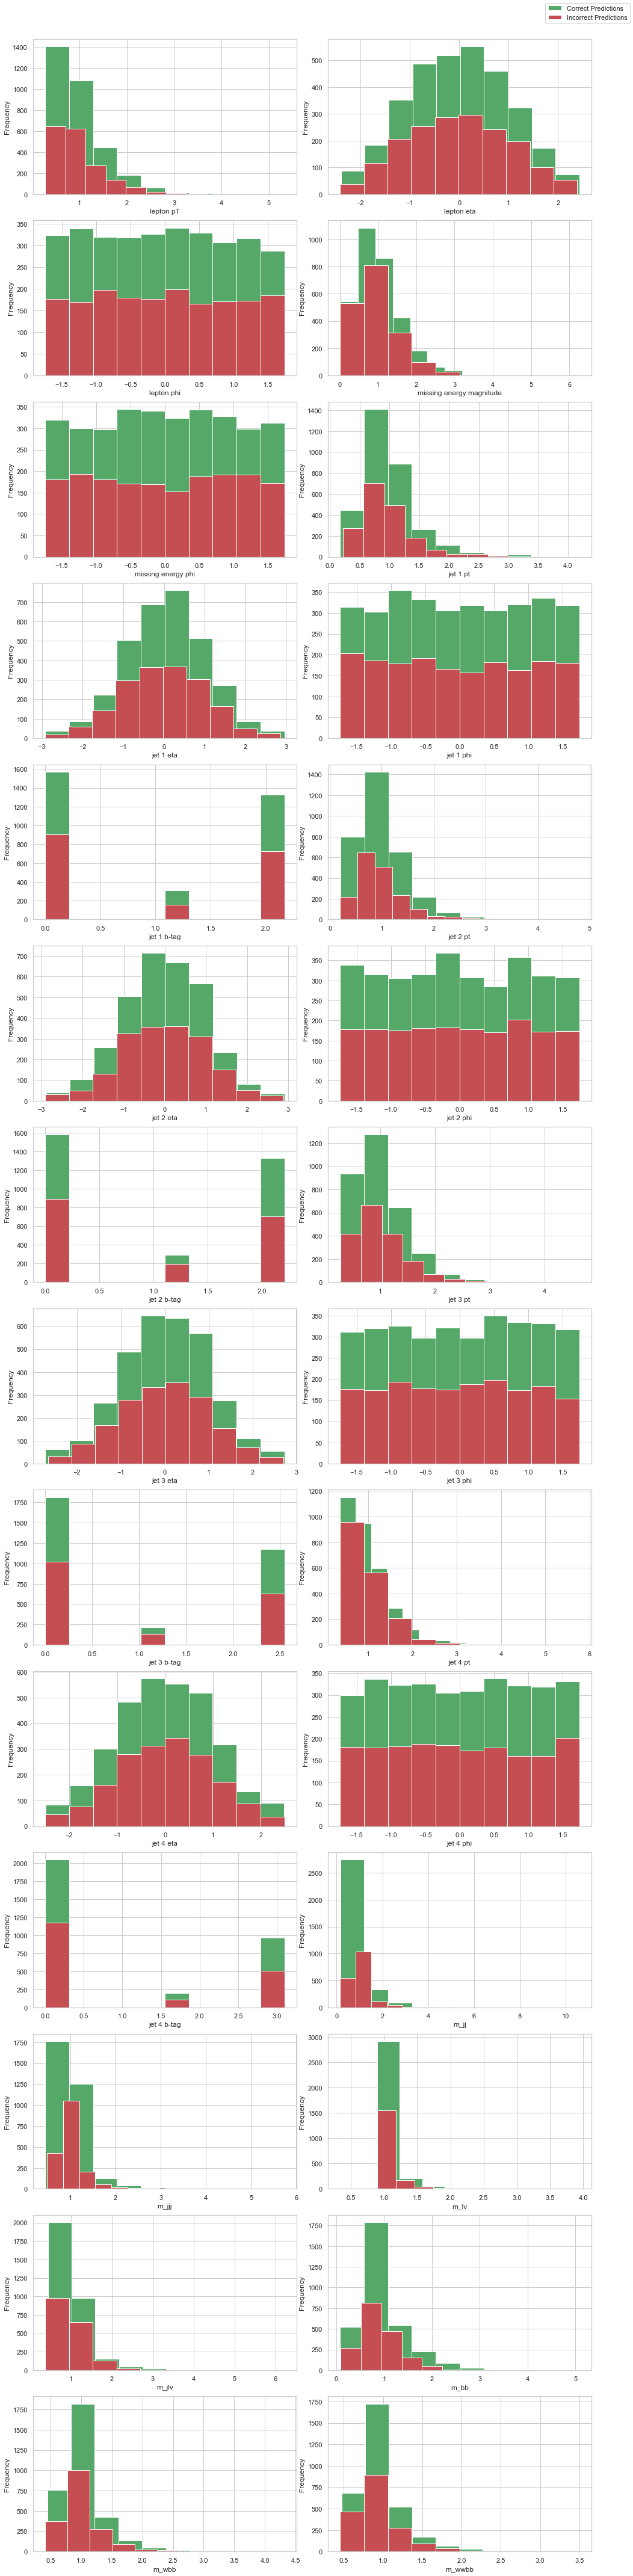

In [20]:
# your code here
fig = plt.figure()
fig, ax = plt.subplots(14,2)
fig.set_figwidth(15)
fig.set_figheight(60)
fig.tight_layout(pad=6,h_pad=2,w_pad=2)

ax_ravel = ax.ravel()

for i in range(28):
    ax_ravel[i].hist(X_train[:,i][correct_indices],color='g',label='Correct Predictions')
    ax_ravel[i].hist(X_train[:,i][incorrect_indices],color='r',label='Incorrect Predictions')
    ax_ravel[i].set_xlabel(data_train.columns[i])
    ax_ravel[i].set_ylabel('Frequency')

fig.legend(labels = ['Correct Predictions','Incorrect Predictions'], loc = 'upper right')

plt.show()

*Your answer here*

For almost all of the predictors the differences in distribution between correct and incorrect classifications are almost identical. The main two predictors that have some differences are the m_jj and m_jjj predictors, although even for those predictors the differences in the distributions are minor.

<div class='exercise-r'>  
 
**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws:
 1. Imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code.
 2. Imagine that you're the TF writing the solutions; make an excellent example implementation.
 3. Use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.
 
 </div>

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [21]:
def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


*Your answer here*

There are a variety of stylistic and design mistakes that we could comment on, but we'll comment on the main ones that limit the interpretability and correctness of the code.

1. The function should not use any variables outside of the definition of the function and the only variables it should use are the ones passed into the function definition. The function makes use of X_train, y_train, X_test, and y_test. If it desires to make use of these variables, it should have them passed in as generic variable in the function definition and then pass in the data when the function is called.

2. The function calculates the accuracies incorrectly. Instead of using "q / len(X)" it should instead use "(len(X)-q)/len(X)"

3. The print statements of the function makes no distinction between the train accuracy and test accuracy. The reason that the boosted accuracy are so low (beyond the incorrect calculations mentioned in part 2) is that in the final else statement (in nested if-else statement) it resets q to be 0 rather than leaving q unchanged. Instead of "q = 0" it hsould use "q = q + 0"

In [28]:
# your code here
def boostmeup(train_X, train_y, test_X, test_y):
    tree = DecisionTreeClassifier(max_depth=3)
    
    tree1 = tree.fit(train_X, train_y)
    
    tree1_predictions_train = tree1.predict(train_X)
    tree1_predictions_test = tree1.predict(test_X)
    print('Non-Boosted train accuracy: ' + str(round(accuracy_score(train_y, tree1_predictions_train),4)))
    print('Non-Boosted test accuracy: ' + str(round(accuracy_score(test_y, tree1_predictions_test),4)))
    
    sample_weight = []
    for i in range(len(tree1_predictions_train)):
        if tree1_predictions[i] == train_y[i]:
            sample_weight.append(1)
        else:
            sample_weight.append(2)
            
    tree2 = tree.fit(train_X, train_y, sample_weight)
    prob_train = (tree1.predict_proba(train_X)+tree2.predict_proba(train_X))/2
    prob_test = (tree1.predict_proba(test_X)+tree2.predict_proba(test_X))/2
    
    y_pred_train = []
    for p in prob_train:
        y_pred_train.append(np.argmax(p))
        
    y_pred_test = []
    for p in prob_test:
        y_pred_test.append(np.argmax(p))
    
    print('Boosted train accuracy: ' + str(round(accuracy_score(train_y,y_pred_train),4)))
    print('Boosted test accuracy: ' + str(round(accuracy_score(test_y,y_pred_test),4)))

boostmeup(X_train, y_train, X_test, y_test)

Non-Boosted train accuracy: 0.6418
Non-Boosted test accuracy: 0.6442
Boosted train accuracy: 0.6134
Boosted test accuracy: 0.6088


<div class='exercise-r'>  
 
**4.3** Now, let us use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.
 
 *Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.
 
 </div>

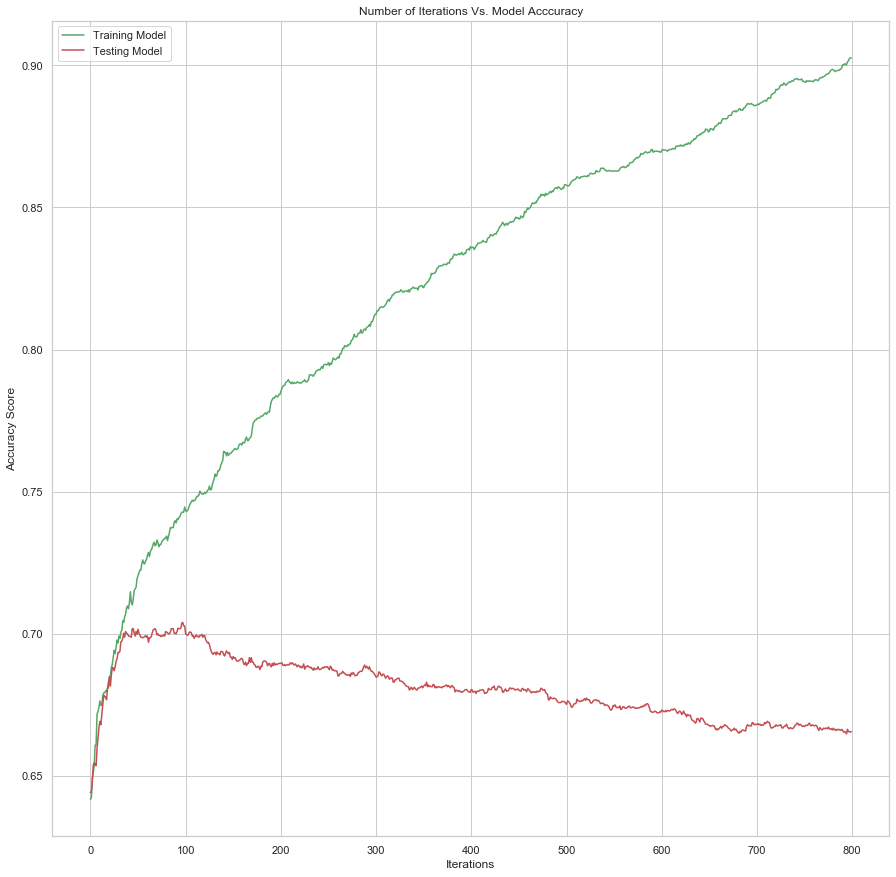

In [31]:
# your code here
#Define parameters
depth = 3
l_rate = 0.05
iters = 800

#Define the model 
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=depth),
    learning_rate = l_rate,
    n_estimators= iters,
    random_state=None
)

#Fit model and make predictions
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

#Save and report the scores
scores_train = list(classifier.staged_score(X_train, y_train,sample_weight = None))
scores_test = list(classifier.staged_score(X_test, y_test, sample_weight = None))

#Plot results
plt.figure(figsize=(15,15))
plt.plot(scores_train, color = 'g', label = 'Training Model')
plt.plot(scores_test, color = 'r', label = 'Testing Model')
plt.legend()
plt.title('Number of Iterations Vs. Model Acccuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy Score')

plt.show()

<div class='exercise-r'>  
 
**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?
 
 (It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)
 
 </div>

<Figure size 432x288 with 0 Axes>

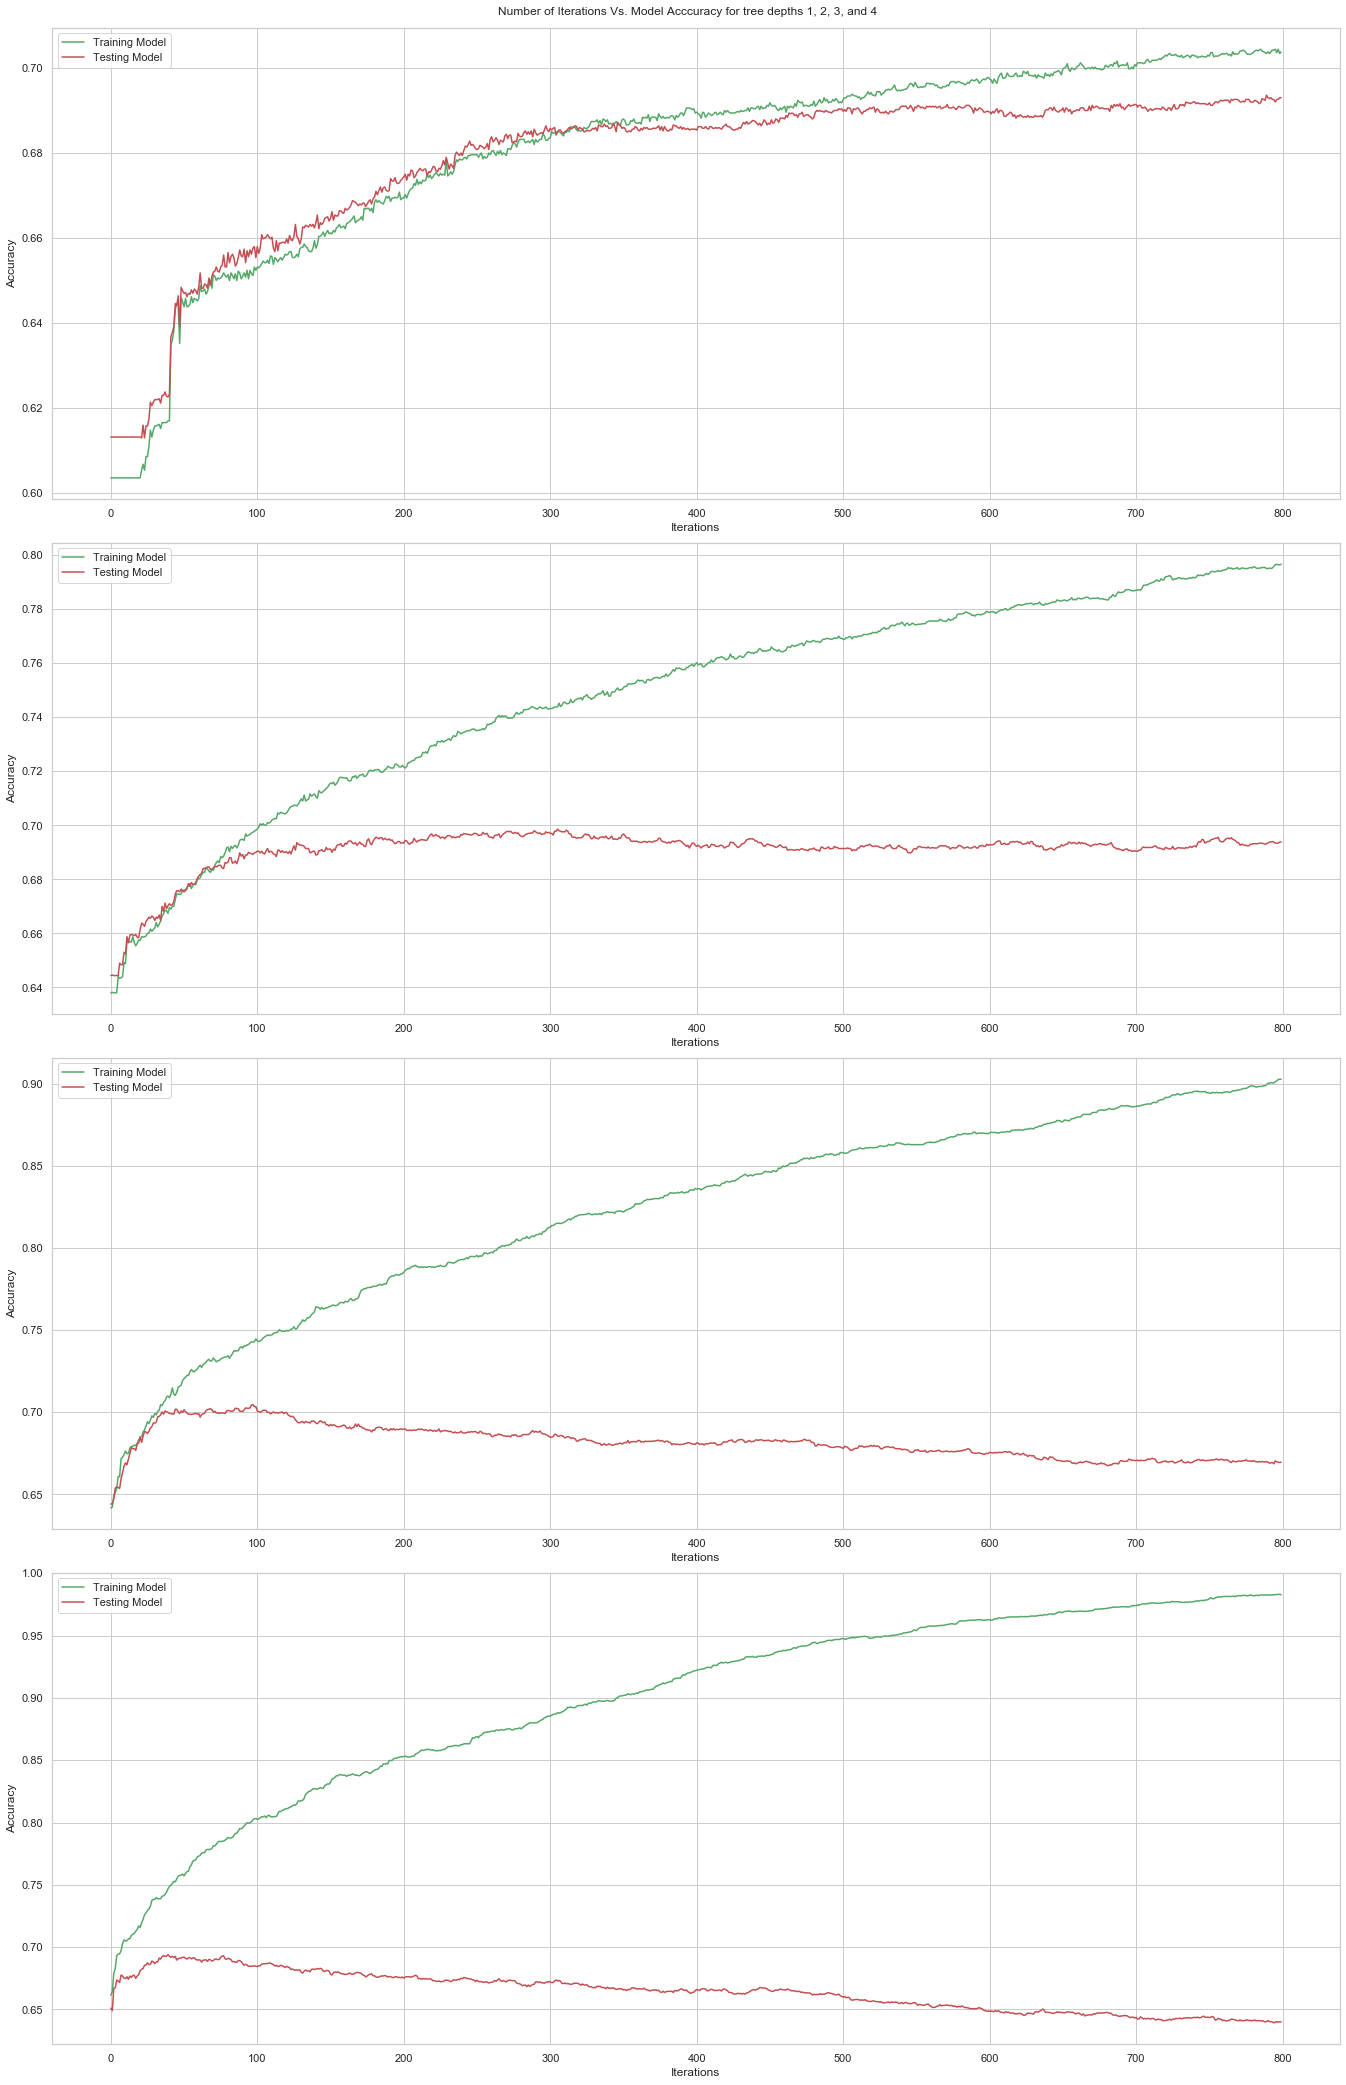

In [42]:
# your code here
l_rate = 0.05
iters = 800

fig = plt.figure()
fig, axs = plt.subplots(4,1)
fig.set_figwidth(20)
fig.set_figheight(30)
fig.tight_layout(pad=6,h_pad=2,w_pad=2)
fig.suptitle('Number of Iterations Vs. Model Acccuracy for tree depths 1, 2, 3, and 4')

for base_learner in range(1,5):
    #Define the model 
    classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=base_learner),
    learning_rate = l_rate,
    n_estimators= iters,
    random_state=None
    )
    
    #Fit the new model and make predictions
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)

    #Save and report the scores  
    scores_train = list(classifier.staged_score(X_train, y_train,sample_weight = None))
    scores_test = list(classifier.staged_score(X_test, y_test, sample_weight = None))
    
    #Set the plots
    axs[base_learner-1].plot(scores_train, color = 'g', label = 'Training Model')
    axs[base_learner-1].plot(scores_test, color = 'r', label = 'Testing Model')
    axs[base_learner-1].set_xlabel('Iterations')
    axs[base_learner-1].set_ylabel('Accuracy')
    axs[base_learner-1].legend()

plt.show()

In [25]:
# your code here


*Your answer here*

For trees of higher tree depth, the training accuracy increases while the testing accuracy decreases, as expected by the bias-variance trade-off. Since trees with higher depths have less bias and will do better on the train set but will have more variance and do worse on the test set. It seems that trees of depth 2 and 3 perform the best on the test set, and tree of depth 2 performs the best because it has the most stable accuracy over many iterations, whereas the tree of depth 3 begins to perform worse on the test set after about 100 iterations.

<div class='exercise-r'>  
 
**4.5** Based on the plot you just made, what combination of base learner depth and the number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?
 </div>

In [26]:
# your code here


*Your answer here*


While testing accuracy peaked around the 100th iteration of the model with the base learner depth = 3, overall the model with a base learner depth = 2 seemed to be the most stable model regardless of the iterations.  The model very quickly improved its accuracy score and held a relatively stable accuracy score between iterations 100-800, whereas the models with base learner depths of 3 and 4 see their test classification accuracies worsen for iterations past 100.  The model with a base learner depth = 1 was similar, but it took many more iterations for the model to begin its "flatline".  Both the model's with base learner depth = 3 and 4 quickly peaked then declined rather linearly as the iterations were increased. The model with base learner depth = 3 consistently performed better than the model with base learner depth = 4 over any number of iterations. 

To get a model with the best possible test set accuracy we'd use a model with a base learner depth = 3, and use the optimal number of iterations = ~100. Alternatively, if we wanted flexibility in the number of iterations we chose, granted as long as we choose more than 100 iterations, we could choose a base learner depth = 2, yielding a similar but slightly lower test classification accuracy than the optimal choice of base learner depth = 3 and number of iterations = 100.

### <div class='exercise'>Question 5 [15pts]: Understanding</div>
[▲ Return to contents](#Contents)
<div class='exercise'>
This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other material outside this homework to answer these questions.
    

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?

</div>


## Answers

<div class='exercise-r'>  
 
**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?
 
 
 </div>

*Your answer here*

Both boosting and bagging are methods used to improve a model's accuracy and reliability.  Both are commonly used with decision tree models like we did in this assignment.  The key difference between the two ensemble methods is how many models we're working with.  

Bagging is the 2 part process of (1) bootstrapping our data to obtain multiple samples and training deeper and deeper decision trees on each new bootstrap then (2) aggregating the results for any given input accross the outputs from all of the different models for that particular input.  By utilizing a sequence of deeper tree's bagging is able to provide a highly expressive model while keeping variance low.

Similarly, boosting attempts to provide a more expressive model, but focuses on reducing the error of a single basic decision tree instead of leveraging the power of multiple tree's of different depths.  Boosting is more of a learning algorithm where we run the same model numerous times and try to adjust for the error each time by utilizing a gradient decent algorithm.  Through each iteration of the boosting method we reduce the residuals of the previous iteration to build a more accurate and expressive model based on the "flaws" in a series of simple models. 

While both boosting and bagging are effective methods for building a more complex and expressive model, boosting does so by utilizing a series of simple models while bagging employs progressively more complex decision tree's to better fit the data.

<div class='exercise-r'>  
 
**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?
 
 </div>

*Your answer here*

The best classifier model we were able to make was the boosted model with a tree depth of 3, and boosted over 100 iterations. It is the only model that has a test classification accuracy of more than 0.7. Up until that point, the best performing model was the original model with a single tree of depth chosen by cross validation.  The boosted model only performed slightly better than the cross validated model, but its likely that it did better because we were given the freedom to limit both tree depth and iterations thus limiting the ability of the model to overfit. 

<div class='exercise-r'>  
 
**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?
 
 </div>

*Your answer here*

Having too many trees in a boosted model is much more of a concern than that of a bagged model.  When bagging a model or utilizing a random forest (which uses bagging) the risk of overfitting your model is small, and not nearly as costly.  Having a boosted model with too many trees can result in the model "bouncing" around the optimum meaning it never actually reduces the residuals to the lowest possible score.  If this were to happen, your model would continue to boost itself until it inaccurately reached the maximum number of iterations and the model's accuracy would either decrease the entire time (as we saw in 4.4) or it would inaccurately predict a false "low" for residual minimization. Having too many tree's in a bagged model is far less costly as most bagging models hardly suffer from overfitting due to the successive nature of the complexity of the model.  

<div class='exercise-r'>  
 
**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?
 
 </div>

*Your answer here*

Bagging better suited to parallelization as the sequence of deeper and deeper tree fitting is very computationally expenseive.  Having multiple computers working on tree building at once would speed up this process and wouldn't be too challenging to set up.  Bagging fundimentally builds the models in parallel then combines it at the end, so splitting up that parallelization between different computers would be easy.  On the other hand, because boosting is an algorithm that learns from itself from successive simple models, running a boosted model on multiple computers would still take about the same time as the time it would take to run it on one computer (the one with the fastest processing speed).  

<div class='exercise-r'>  
 
**5.5** Which of these techniques can be extended to regression tasks? How?
 
 </div>

*Your answer here*

All of these ensemble techniques can be extended to regression tasks by taking the continuous range of values in a regression task and classifying the entire continous range into discrete ranges of values so that these discrete ranges are subset of the entire continous range and so they may act as classes in which these ensemble classification techniques can be exteneded to. Essentially, all of these techniques would be non-parametric ways of approaching regression tasks.

### End of Notebook